In [1]:
import os, sys
from pathlib import Path

def find_project_root(marker_dirs=('src','data')):
    p = Path().resolve()
    while True:
        if all((p / d).is_dir() for d in marker_dirs):
            return p
        if p.parent == p:
            raise RuntimeError(f"Could not find project root containing {marker_dirs}")
        p = p.parent

project_root = find_project_root()
os.chdir(project_root)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("✔️ Project root:", project_root)


✔️ Project root: /Users/LeoWang/Desktop/CU/Risk/Risk_Project


In [ ]:
# ── Cell 2: Imports & Config ───────────────────────────────────────────────────
import pandas as pd
import numpy as np
from tqdm.notebook import trange
from scipy.stats   import chi2

from risk_project.config      import (
    STOCK_FILES,
    TARGET_NOTIONAL,
    P_VAR,
    HORIZON_DAYS,
    WINDOW,
    BACKTEST_START,
    BACKTEST_END,
    TRADING_DAYS_YR,
    MC_PATHS,
    SEED
)
from risk_project.data_loader import load_price_series
from risk_project.var_es      import parametric_var_es, historical_var_es
from risk_project.monte_carlo import monte_carlo
from risk_project.backtest    import compute_portfolio_pnl, compute_exceptions, kupiec_test

print("Settings:")
print(f"  STOCK_FILES     = {STOCK_FILES}")
print(f"  TARGET_NOTIONAL = {TARGET_NOTIONAL}")
print(f"  P_VaR           = {P_VAR}")
print(f"  HORIZON_DAYS    = {HORIZON_DAYS}")
print(f"  WINDOW          = {WINDOW}")
print(f"  BACKTEST_START  = {BACKTEST_START}")
print(f"  BACKTEST_END    = {BACKTEST_END}")
print(f"  TRADING_DAYS_YR = {TRADING_DAYS_YR}")
print(f"  MC_PATHS, SEED  = {MC_PATHS}, {SEED}")


Settings:
  STOCK_FILES     = ['data/AAPL-bloomberg.csv', 'data/AMZN-bloomberg.csv']
  TARGET_NOTIONAL = 100000
  P_VaR           = 0.99
  HORIZON_DAYS    = 1
  WINDOW          = 250
  BACKTEST_START  = None
  BACKTEST_END    = None
  TRADING_DAYS_YR = 252
  MC_PATHS, SEED  = 10000, 42


In [3]:
# 1) Load price series into a dict of pd.Series
series   = load_price_series(STOCK_FILES)

# 2) Combine into single DataFrame & drop any dates with missing data
price_df = pd.DataFrame(series).dropna()

# 3) Build $-notional positions so each ticker has TARGET_NOTIONAL exposure
positions = {
    s: TARGET_NOTIONAL / price_df[s].iloc[-1]
    for s in price_df.columns
}

# 4) Compute realized P&L series (1-day horizon)
pnl = compute_portfolio_pnl(series, positions, horizon_days=HORIZON_DAYS)

print("Price DataFrame head:")
display(price_df.head())
print("Positions (shares):", positions)
print("P&L head:")
display(pnl.head())


Price DataFrame head:


,AAPL,AMZN
Dates,,
1997-05-15,0.158,0.098
1997-05-16,0.154,0.086
1997-05-19,0.152,0.085
1997-05-20,0.154,0.082
1997-05-21,0.151,0.071


Positions (shares): {'AAPL': 429.88565041698905, 'AMZN': 429.6270836913559}
P&L head:


Dates
1982-11-15   NaN
1982-11-16   NaN
1982-11-17   NaN
1982-11-18   NaN
1982-11-19   NaN
dtype: float64

In [4]:
# ── Cell 4: Rolling VaR Calculation (with proper per‐window calibration) ──
import pandas as pd
from tqdm.notebook    import trange
from risk_project.config       import P_VAR, HORIZON_DAYS, WINDOW, TRADING_DAYS_YR, MC_PATHS, SEED
from risk_project.calibration  import estimate_mu_sigma, estimate_covariance_matrix
from risk_project.var_es       import parametric_var_es, historical_var_es
from risk_project.monte_carlo  import monte_carlo

dates      = price_df.index
param_vars = []
hist_vars  = []
mc_vars    = []
roll_dates = []

for i in trange(WINDOW, len(dates)):
    # 1) window of history
    date       = dates[i]
    hist_slice = price_df.iloc[i-WINDOW : i]

    # 2a) Calibrate parametric drift & covariance on this window
    #    μ_ann: dict symbol→annual drift;  cov_ann: DataFrame annual cov
    mu_ann = {
        s: estimate_mu_sigma(hist_slice[s], trading_days_per_year=TRADING_DAYS_YR)[0]
        for s in hist_slice.columns
    }
    cov_ann = estimate_covariance_matrix(
        {s: hist_slice[s] for s in hist_slice.columns},
        trading_days_per_year=TRADING_DAYS_YR
    )

    # 2b) Parametric VaR
    pv, _ = parametric_var_es(
        positions,
        hist_slice.to_dict('series'),
        mu_ann,
        cov_ann,
        p=P_VAR,
        horizon_days=HORIZON_DAYS,
        trading_days=TRADING_DAYS_YR
    )
    param_vars.append(pv)

    # 3) Historical VaR (long)
    hv, _ = historical_var_es(
        positions,
        hist_slice.to_dict('series'),
        p=P_VAR,
        horizon_days=HORIZON_DAYS,
        is_long=True
    )
    hist_vars.append(hv)

    # 4) Monte Carlo via unified interface
    mcv = monte_carlo(
        price_df,
        positions,
        idx=i,
        is_long=True,
        is_var=True,
        p=P_VAR,
        horizon_days=HORIZON_DAYS,
        window=WINDOW,
        trading_days=TRADING_DAYS_YR,
        n_sims=MC_PATHS,
        seed=SEED
    )
    mc_vars.append(mcv)

    roll_dates.append(date)

# 5) Build the three VaR series
param_series = pd.Series(param_vars, index=roll_dates)
hist_series  = pd.Series(hist_vars,  index=roll_dates)
mc_series    = pd.Series(mc_vars,    index=roll_dates)

print("✔️ Rolling VaR series computed.")


  0%|          | 0/6730 [00:00<?, ?it/s]

✔️ Rolling VaR series computed.


In [5]:
# Align P&L to our VaR dates
pnl_bt = pnl.reindex(roll_dates)

# Function to run backtest and print results
def backtest_report(label, var_series):
    exc = compute_exceptions(pnl_bt, var_series)
    n   = len(exc)
    x   = exc.sum()
    LR, p_val = kupiec_test(x, n, P_VAR)   # ← pass (n_exceptions, n_obs, p)
    print(f"{label} rolling VaR backtest:")
    print(f"  Exceptions: {x} (~{x/n:.2%} of {n} days)")
    print(f"  Kupiec LR = {LR:.2f}, p-value = {p_val:.3e}\n")

backtest_report("Parametric",  param_series)
backtest_report("Historical", hist_series)
backtest_report("Monte Carlo", mc_series)


Parametric rolling VaR backtest:
  Exceptions: 123 (~1.83% of 6730 days)
  Kupiec LR = 37.41, p-value = 9.569e-10

Historical rolling VaR backtest:
  Exceptions: 143 (~2.12% of 6730 days)
  Kupiec LR = 65.02, p-value = 7.772e-16

Monte Carlo rolling VaR backtest:
  Exceptions: 157 (~2.33% of 6730 days)
  Kupiec LR = 87.80, p-value = 0.000e+00



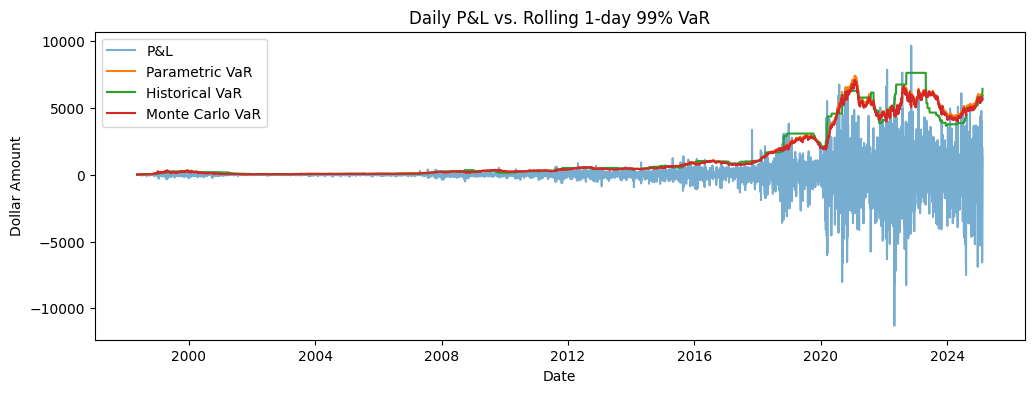

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(pnl_bt.index,     pnl_bt.values,      alpha=0.6, label="P&L")
plt.plot(param_series.index, param_series.values,  label="Parametric VaR")
plt.plot(hist_series.index,  hist_series.values,   label="Historical VaR")
plt.plot(mc_series.index,    mc_series.values,     label="Monte Carlo VaR")
plt.title("Daily P&L vs. Rolling 1-day 99% VaR")
plt.xlabel("Date"); plt.ylabel("Dollar Amount")
plt.legend(loc="upper left")
plt.show()


In [7]:
import pandas as pd

# build a table of raw exception counts
summary = pd.DataFrame({
    "Parametric":    compute_exceptions(pnl_bt, param_series).sum(),
    "Historical":    compute_exceptions(pnl_bt, hist_series).sum(),
    "Monte Carlo":   compute_exceptions(pnl_bt, mc_series).sum(),
}, index=["Exceptions"]).T

# total days
n_obs = len(pnl_bt)

# exception rate
summary["Exception Rate"] = (summary["Exceptions"] / n_obs).map("{:.2%}".format)

# run kupiec_test over each row
results = [
    kupiec_test(int(row["Exceptions"]), n_obs, P_VAR)
    for idx, row in summary.iterrows()
]
# unpack into two columns
summary["Kupiec LR"], summary["p-value"] = zip(*results)

# format p-value
summary["p-value"] = summary["p-value"].map("{:.3e}".format)

summary


,Exceptions,Exception Rate,Kupiec LR,p-value
Parametric,123,1.83%,37.410887,9.569e-10
Historical,143,2.12%,65.017098,7.772e-16
Monte Carlo,157,2.33%,87.797957,0.000e+00


# Parametric VaR for Long & Short Positions

In this section, we compute 5-day 99% VaR and 97.5% ES for Apple, Amazon, and the combined portfolio—both for long and short positions—using (a) the direct portfolio volatility estimate and (b) the variance-component approach.


In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from risk_project.data_loader import load_price_series
from risk_project.config      import STOCK_FILES  # or your own file list

# 1. Load price series (dict of ticker ➔ pd.Series)
series = load_price_series(STOCK_FILES)
prices = pd.DataFrame(series)  # DataFrame: columns = tickers, index = dates

# 2. Compute daily returns
returns = prices.pct_change().dropna()

# 3. Align on common dates
returns = returns.dropna(axis=0, how='any')
print(f"Data spans {returns.index[0].date()} → {returns.index[-1].date()}, n={len(returns)}")


Data spans 1997-05-16 → 2025-02-11, n=6979


In [9]:
window = 5 * 252  # 5-year window
rp = pd.DataFrame(index=returns.index[window-1:])

# Per-ticker means, variances, vols
for col in returns.columns:
    rp[f"{col}_mean"] = returns[col].rolling(window).mean()
    rp[f"{col}_var"]  = returns[col].rolling(window).var()
    rp[f"{col}_vol"]  = np.sqrt(rp[f"{col}_var"])

# Correlation
rp['corr'] = returns['AAPL'].rolling(window).corr(returns['AMZN'])

# Weights by $ value
prices_aligned = prices.loc[rp.index]
values = prices_aligned * np.array([25773, 26596])  # share counts
total_val = values.sum(axis=1)
rp['w_AAPL'] = values.iloc[:,0] / total_val
rp['w_AMZN'] = values.iloc[:,1] / total_val

# Portfolio mean/var/vol
port_r = (returns['AAPL'] * rp['w_AAPL'] + returns['AMZN'] * rp['w_AMZN']).loc[rp.index]
rp['p_mean'] = port_r.rolling(window).mean()
rp['p_var']  = port_r.rolling(window).var()
rp['p_vol']  = np.sqrt(rp['p_var'])

rp.dropna(inplace=True)
print(f"Rolling stats for {len(rp)} days")


Rolling stats for 4461 days


In [10]:
def calc_param_var_es(df, position_size=10000, α_var=0.99, α_es=0.975,
                      days=5, short=False):
    z_var = norm.ppf(α_var)
    z_es  = norm.ppf(α_es)
    es_fac = norm.pdf(z_es)/(1-α_es)
    sign = 1 if short else -1
    T = days/252

    out = pd.DataFrame(index=df.index)
    for asset in ['AAPL','AMZN']:
        μ = df[f"{asset}_mean"] * 252
        σ = df[f"{asset}_vol"] * np.sqrt(252)
        μT, σT = μ*T, σ*np.sqrt(T)
        out[f"{asset}_var"] = position_size*(z_var*σT + sign*μT)
        out[f"{asset}_es"]  = position_size*(σT*es_fac + sign*μT)

    # Portfolio direct
    μp, σp = df['p_mean']*252, df['p_vol']*np.sqrt(252)
    μT_p, σT_p = μp*T, σp*np.sqrt(T)
    out['port_var_dir'] = position_size*(z_var*σT_p + sign*μT_p)
    out['port_es_dir']  = position_size*(σT_p*es_fac + sign*μT_p)

    # Portfolio component
    var_comp = (
        df['w_AAPL']**2 * df['AAPL_var'] +
        df['w_AMZN']**2 * df['AMZN_var'] +
        2*df['w_AAPL']*df['w_AMZN']*df['corr']*
        df['AAPL_vol']*df['AMZN_vol']
    )
    σc = np.sqrt(var_comp)*np.sqrt(252)
    μc = (df['w_AAPL']*df['AAPL_mean'] + df['w_AMZN']*df['AMZN_mean'])*252
    μT_c, σT_c = μc*T, σc*np.sqrt(T)
    out['port_var_cmp'] = position_size*(z_var*σT_c + sign*μT_c)
    out['port_es_cmp']  = position_size*(σT_c*es_fac + sign*μT_c)

    return out

# Run for both long and short
long_res  = calc_param_var_es(rp, short=False)
short_res = calc_param_var_es(rp, short=True)


In [11]:
def print_com(lr, sr):
    metrics = [
        ('AAPL_var',         'AAPL'),
        ('AMZN_var',         'AMZN'),
        ('port_var_dir',     'Portfolio (Direct)'),
        ('port_var_cmp',     'Portfolio (Components)')
    ]

    print("Avg. 5-day 99% VaR (Long vs. Short)\n" + "="*50)
    for col, label in metrics:
        lv = lr[col].mean()
        sv = sr[col].mean()
        print(f"{label:>20}: Long = ${lv:8.2f} | Short = ${sv:8.2f} | Δ=${sv-lv:6.2f}")

    print("\nDirect vs. Component (Short Portfolio)\n" + "-"*50)
    d = sr['port_var_dir']
    c = sr['port_var_cmp']
    print(f"Mean Δ: {(d - c).mean():.2f}")
    print(f"MSE: {((d - c)**2).mean():.2f}")
    print(f"Corr: {d.corr(c):.4f}")

print_com(long_res, short_res)


Avg. 5-day 99% VaR (Long vs. Short)
                AAPL: Long = $  991.61 | Short = $ 1128.22 | Δ=$136.62
                AMZN: Long = $ 1174.93 | Short = $ 1303.20 | Δ=$128.26
  Portfolio (Direct): Long = $  911.12 | Short = $ 1046.90 | Δ=$135.78
Portfolio (Components): Long = $  912.16 | Short = $ 1048.31 | Δ=$136.15

Direct vs. Component (Short Portfolio)
--------------------------------------------------
Mean Δ: -1.41
MSE: 739.13
Corr: 0.9938


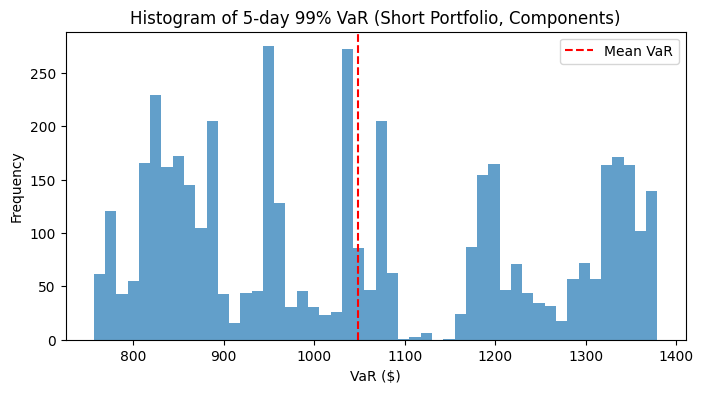

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(short_res['port_var_cmp'], bins=50, alpha=0.7)
plt.axvline(short_res['port_var_cmp'].mean(),
            color='red', linestyle='--', label='Mean VaR')
plt.title('Histogram of 5-day 99% VaR (Short Portfolio, Components)')
plt.xlabel('VaR ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


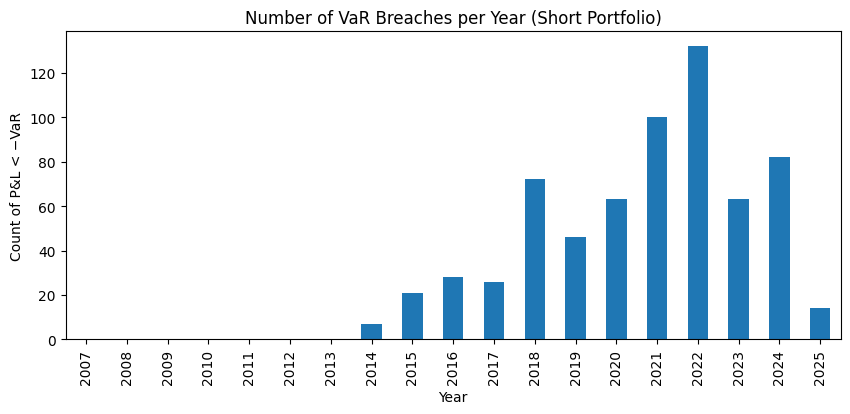

In [13]:
# 1) align your P&L
pnl_5d = compute_portfolio_pnl(series, positions, horizon_days=5)  
pnl_5d = pnl_5d.loc[short_res.index]  # only dates where we have VaR

# 2) flag breaches
breach = pnl_5d < -short_res['port_var_cmp']

# 3) count by calendar year
breaches_by_year = breach.groupby(breach.index.year).sum()

# 4) plot
plt.figure(figsize=(10,4))
breaches_by_year.plot(kind='bar')
plt.title('Number of VaR Breaches per Year (Short Portfolio)')
plt.xlabel('Year')
plt.ylabel('Count of P&L < −VaR')
plt.show()


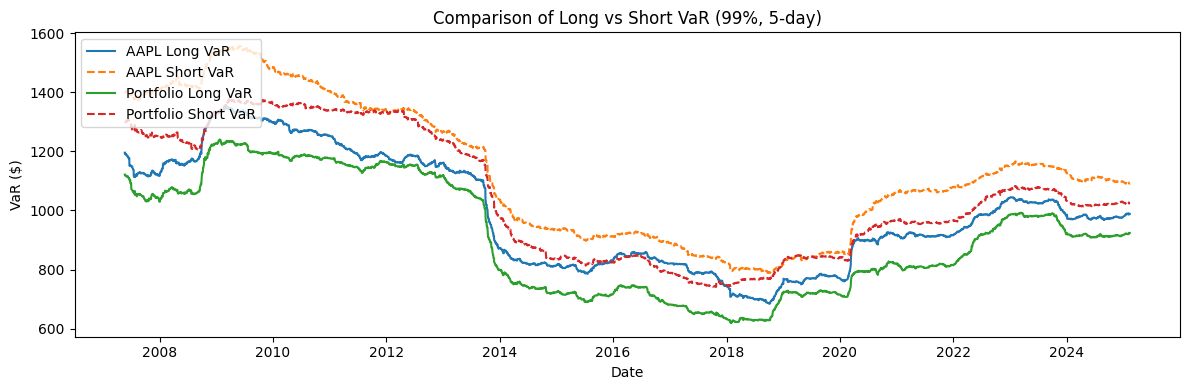

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare
dates = long_res.index

# Plot
plt.figure(figsize=(12, 4))
plt.plot(dates, long_res['AAPL_var'],      label='AAPL Long VaR')
plt.plot(dates, short_res['AAPL_var'],     '--', label='AAPL Short VaR')
plt.plot(dates, long_res['port_var_dir'],  label='Portfolio Long VaR')
plt.plot(dates, short_res['port_var_dir'], '--', label='Portfolio Short VaR')

# Format
plt.title('Comparison of Long vs Short VaR (99%, 5-day)')
plt.xlabel('Date')
plt.ylabel('VaR ($)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


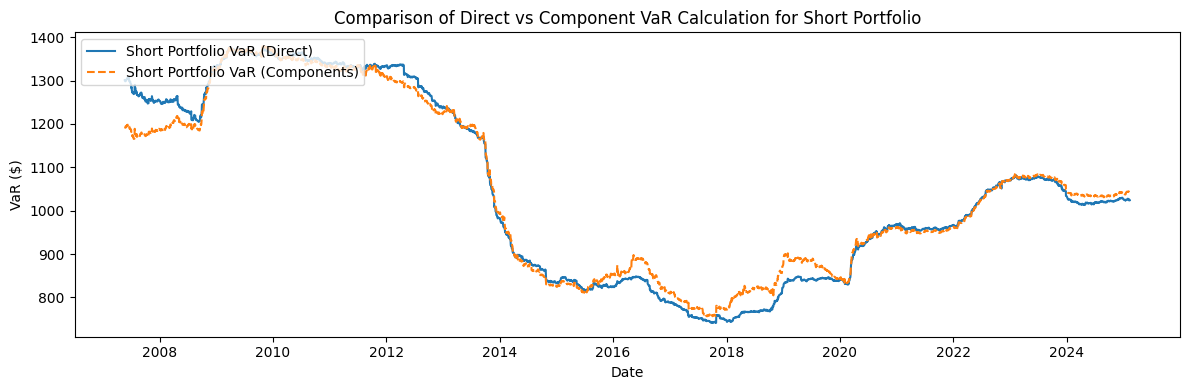

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(dates, short_res['port_var_dir'], label='Short Portfolio VaR (Direct)')
plt.plot(dates, short_res['port_var_cmp'], '--', label='Short Portfolio VaR (Components)')

plt.title('Comparison of Direct vs Component VaR Calculation for Short Portfolio')
plt.xlabel('Date')
plt.ylabel('VaR ($)')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


# Comparison of 97.5% ES vs. 99% VaR (Short Positions)

In this section we calculate 5-day 99% VaR and 97.5% ES for Apple, Amazon, and the portfolio (short positions), then compare their ratios and plot their paths over time.


In [16]:
# ── Cell: Q5 Summary Table ─────────────────────────────────────────
from scipy.stats import norm

def print_ES_VaR(res):
    metrics = [
        ("AAPL_var",      "AAPL_es",      "AAPL"),
        ("AMZN_var",      "AMZN_es",      "AMZN"),
        ("port_var_dir",  "port_es_dir",  "Portfolio (Direct)"),
        ("port_var_cmp",  "port_es_cmp",  "Portfolio (Components)")
    ]

    print("Q5: Avg. 97.5% ES vs. 99% VaR (Short Positions)\n" + "="*60)
    for var_col, es_col, label in metrics:
        v = res[var_col].mean()
        e = res[es_col].mean()
        print(f"{label:>20}: VaR = ${v:8.2f} | ES = ${e:8.2f} | ES/Var = {e/v:.4f}")

    z_var = norm.ppf(0.99)
    z_es  = norm.ppf(0.975)
    theor = (norm.pdf(z_es)/(1-0.975)) / z_var
    print(f"\nTheoretical Normal ES/Var Ratio: {theor:.4f}")

print_ES_VaR(short_res)


Q5: Avg. 97.5% ES vs. 99% VaR (Short Positions)
                AAPL: VaR = $ 1128.22 | ES = $ 1133.44 | ES/Var = 1.0046
                AMZN: VaR = $ 1303.20 | ES = $ 1309.30 | ES/Var = 1.0047
  Portfolio (Direct): VaR = $ 1046.90 | ES = $ 1051.72 | ES/Var = 1.0046
Portfolio (Components): VaR = $ 1048.31 | ES = $ 1053.14 | ES/Var = 1.0046

Theoretical Normal ES/Var Ratio: 1.0049


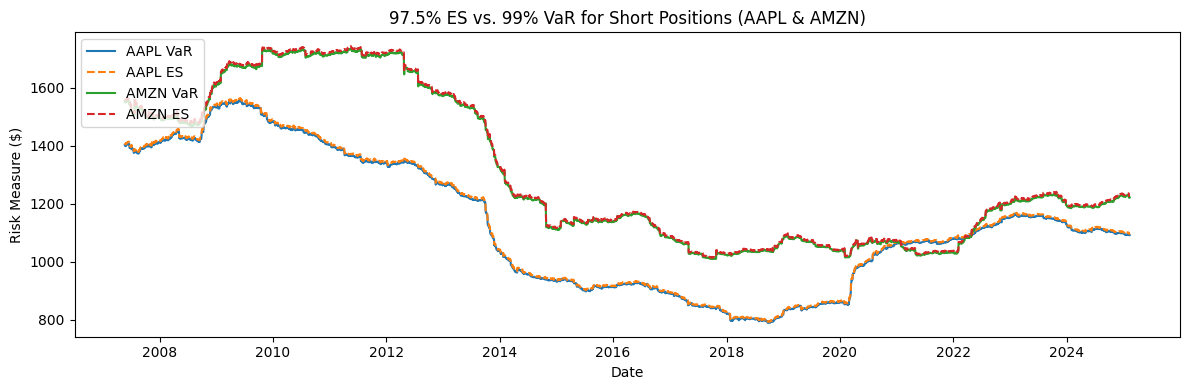

In [17]:
# ── Cell: Plot AAPL & AMZN VaR vs. ES ──────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dates = short_res.index

plt.figure(figsize=(12, 4))
plt.plot(dates, short_res["AAPL_var"], label="AAPL VaR")
plt.plot(dates, short_res["AAPL_es"],  "--", label="AAPL ES")
plt.plot(dates, short_res["AMZN_var"], label="AMZN VaR")
plt.plot(dates, short_res["AMZN_es"],  "--", label="AMZN ES")

plt.title("97.5% ES vs. 99% VaR for Short Positions (AAPL & AMZN)")
plt.xlabel("Date")
plt.ylabel("Risk Measure ($)")
plt.legend(loc="upper left")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()


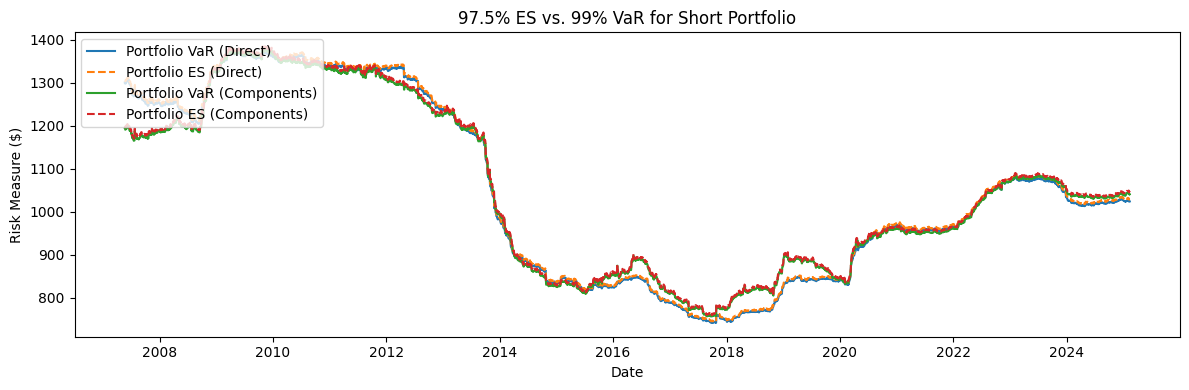

In [18]:
# ── Cell: Plot Portfolio VaR vs. ES ───────────────────────────────
plt.figure(figsize=(12, 4))
plt.plot(dates, short_res["port_var_dir"],  label="Portfolio VaR (Direct)")
plt.plot(dates, short_res["port_es_dir"],   "--", label="Portfolio ES (Direct)")
plt.plot(dates, short_res["port_var_cmp"],  label="Portfolio VaR (Components)")
plt.plot(dates, short_res["port_es_cmp"],   "--", label="Portfolio ES (Components)")

plt.title("97.5% ES vs. 99% VaR for Short Portfolio")
plt.xlabel("Date")
plt.ylabel("Risk Measure ($)")
plt.legend(loc="upper left")
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()
